# Machine Learning 1 - Nearest Neighbors and Decision Trees

## Lab objectives

* Classification with decision trees and random forests.
* Cross-validation and evaluation.

In [1]:
# imports
from lab_tools import CIFAR10, get_hog_image
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.evaluate import bias_variance_decomp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold, validation_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
dataset = CIFAR10('data/CIFAR10/')

# data
X_train, y_train = dataset.train['hog'], dataset.train['labels']
X_test, y_test  = dataset.test['hog'],  dataset.test['labels']

Pre-loading training data
Pre-loading test data


In [10]:
# standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(dataset.train['hog'])
X_test_scaled = scaler.transform(dataset.test['hog'])

# fit PCA and examine cumulative explained variance
pca = PCA().fit(X_train_scaled)
cumvar = np.cumsum(pca.explained_variance_ratio_)
# find how many components to retain, e.g. 90% variance
n_components_90 = np.searchsorted(cumvar, 0.90) + 1  

print(f"{n_components_90} components explain ≥90% of variance")

# project down
pca = PCA(n_components=n_components_90, whiten=True, random_state=0)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)
print("Resulting shape:", X_train_pca.shape)

183 components explain ≥90% of variance
Resulting shape: (15000, 183)


# 1. Nearest Neighbor

The following example uses the Nearest Neighbor algorithm on the Histogram of Gradient decriptors in the dataset.

In [6]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit( dataset.train['hog'], dataset.train['labels'] )

KNeighborsClassifier(n_neighbors=1)

* What is the **descriptive performance** of this classifier ?
* Modify the code to estimate the **predictive performance**.
* Use cross-validation to find the best hyper-parameters for this method.

In [11]:
%%time

# classifier
clf = KNeighborsClassifier(metric='manhattan', n_neighbors=7)

# descriptive performance (on full training set)
clf.fit(X_train_scaled, y_train)
y_train_pred = clf.predict(X_train_scaled)
train_acc = accuracy_score(y_train, y_train_pred)
train_cm  = confusion_matrix(y_train, y_train_pred)

print("--- Descriptive performance ---")
print(f"Training accuracy: {train_acc:.4f}")
print("Training confusion matrix:")
print(train_cm)

# predictive performance (5‑fold cross‑validation)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(
    clf, 
    X_train_scaled, 
    y_train, 
    cv=cv, 
    scoring='accuracy', 
    n_jobs=-1
)
y_cv_pred = cross_val_predict(clf, X_train_scaled, y_train, cv=5)
cv_acc = accuracy_score(y_train, y_cv_pred)
cv_cm = confusion_matrix(y_train, y_cv_pred)

print("\n--- Predictive performance (5‑fold CV) ---")
print("Fold accuracies: ", np.round(cv_scores, 4))
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
print(f"Overall CV accuracy: {cv_acc:.4f}")
print("CV confusion matrix:")
print(cv_cm)

--- Descriptive performance ---
Training accuracy: 0.8475
Training confusion matrix:
[[4175  579  246]
 [ 349 4231  420]
 [  91  602 4307]]

--- Predictive performance (5‑fold CV) ---
Fold accuracies:  [0.782  0.7927 0.792  0.783  0.7843]
Mean CV accuracy: 0.7868
Overall CV accuracy: 0.7859
CV confusion matrix:
[[3872  791  337]
 [ 440 3924  636]
 [ 138  870 3992]]
CPU times: total: 2min 10s
Wall time: 31.6 s


In [7]:
%%time

# bias - Variance decomposition

# bias–Variance on the train set
mse_desc, bias_desc, var_desc = bias_variance_decomp(
    clf,
    X_train_scaled, y_train,
    X_train_scaled, y_train,
    loss='0-1_loss',
    random_seed=123
)
print("\nDescriptive bias–variance decomposition:")
print(f"  Avg expected loss (MSE): {mse_desc:.3f}")
print(f"  Avg bias:                {bias_desc:.3f}")
print(f"  Avg variance:            {var_desc:.3f}")

# bias–Variance on the test set
mse_pred, bias_pred, var_pred = bias_variance_decomp(
    clf,
    X_train_scaled, y_train,
    X_test,  y_test,
    loss='0-1_loss',
    random_seed=123
)
print("\nPredictive bias–variance decomposition:")
print(f"  Avg expected loss (MSE): {mse_pred:.3f}")
print(f"  Avg bias:                {bias_pred:.3f}")
print(f"  Avg variance:            {var_pred:.3f}")


Descriptive bias–variance decomposition:
  Avg expected loss (MSE): 0.227
  Avg bias:                0.172
  Avg variance:            0.159

Predictive bias–variance decomposition:
  Avg expected loss (MSE): 0.664
  Avg bias:                0.667
  Avg variance:            0.239
CPU times: total: 31min 43s
Wall time: 4min 12s


In [12]:
%%time

# define the hyperparameter grid to search
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'metric': ['euclidean', 'manhattan']
}

# set up and run a grid search over the above parameters
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)

# report best results
print("\n--- Hyperparameter search results ---")
print("Best parameters: ", grid.best_params_)
print(f"Best 5‑fold CV accuracy: {grid.best_score_:.4f}")


--- Hyperparameter search results ---
Best parameters:  {'metric': 'manhattan', 'n_neighbors': 14}
Best 5‑fold CV accuracy: 0.7870
CPU times: total: 1.42 s
Wall time: 1min 39s


C:\Users\gianm\miniforge3\envs\test\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


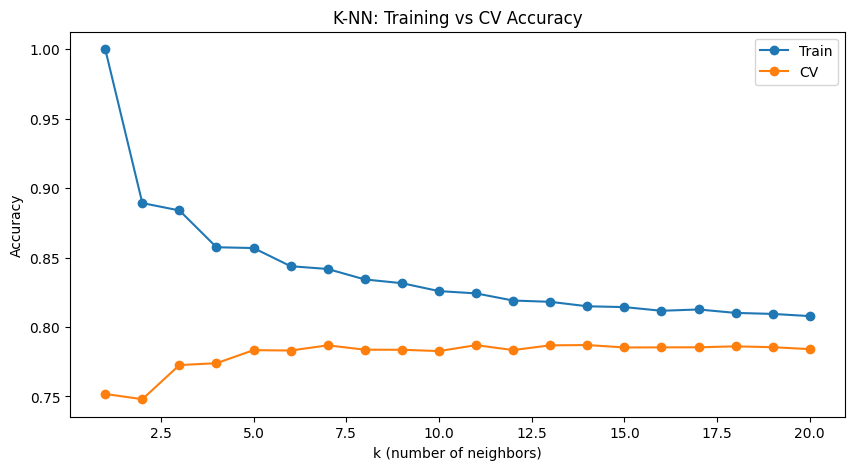

CPU times: total: 3.58 s
Wall time: 7min 14s


In [13]:
%%time

# plot n_neighbors validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
param_range = range(1, 21)
train_scores, val_scores = validation_curve(
    KNeighborsClassifier(metric='manhattan'),
    X_train_scaled, y_train,
    param_name="n_neighbors",
    param_range=param_range,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

plt.figure(figsize=(10,5))
plt.plot(
    param_range,
    train_scores.mean(axis=1),
    marker='o',
    linestyle='-',
    color='C0',
    label="Train"
)
plt.plot(
    param_range,
    val_scores.mean(axis=1),
    marker='o',
    color='C1',
    linestyle='-',
    label="CV"
)
plt.xlabel('k (number of neighbors)')
plt.ylabel('Accuracy')
plt.title('K-NN: Training vs CV Accuracy')
plt.legend(loc='best')
plt.show()

In [16]:
%%time

# final model
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=7)

# (re-)fit it on the *entire* training set
knn.fit(X_train_scaled, y_train)

# predict on the test set
y_test_pred = knn.predict(X_test_scaled)

# compute and print your final metrics
test_acc = accuracy_score(y_test, y_test_pred)
test_cm  = confusion_matrix(y_test, y_test_pred)

print("--- Final Test-Set Performance ---")
print(f"Test accuracy: {test_acc:.4f}\n")
print("Confusion matrix:")
print(test_cm, "\n")
print("Classification report:")
print(classification_report(y_test, y_test_pred, target_names=dataset.labels))

--- Final Test-Set Performance ---
Test accuracy: 0.7897

Confusion matrix:
[[782 162  56]
 [ 87 789 124]
 [ 22 180 798]] 

Classification report:
              precision    recall  f1-score   support

    Airplane       0.88      0.78      0.83      1000
        Bird       0.70      0.79      0.74      1000
       Horse       0.82      0.80      0.81      1000

    accuracy                           0.79      3000
   macro avg       0.80      0.79      0.79      3000
weighted avg       0.80      0.79      0.79      3000

CPU times: total: 14.6 s
Wall time: 2.5 s


## 2. Decision Trees

[Decision Trees](http://scikit-learn.org/stable/modules/tree.html#tree) classify the data by splitting the feature space according to simple, single-feature rules. Scikit-learn uses the [CART](https://en.wikipedia.org/wiki/Predictive_analytics#Classification_and_regression_trees_.28CART.29) algorithm for [its implementation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) of the classifier. 

* **Create a simple Decision Tree classifier** using scikit-learn and train it on the HoG training set.
* Use cross-validation to find the best hyper-paramters for this method.

In [15]:
%%time

# classifier
clf = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=42)

# descriptive performance (on full training set)
clf.fit(X_train_scaled, y_train)
y_train_pred = clf.predict(X_train_scaled)
train_acc = accuracy_score(y_train, y_train_pred)
train_cm = confusion_matrix(y_train, y_train_pred)

print("--- Descriptive performance ---")
print(f"Training accuracy: {train_acc:.4f}")
print("Training confusion matrix:")
print(train_cm)

# predictive performance (5‑fold cross‑validation)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(
    clf,
    X_train_scaled,
    y_train, 
    cv=cv, 
    scoring='accuracy', 
    n_jobs=-1
)
y_cv_pred = cross_val_predict(clf, X_train_scaled, y_train, cv=5)
cv_acc = accuracy_score(y_train, y_cv_pred)
cv_cm = confusion_matrix(y_train, y_cv_pred)

print("\n--- Predictive performance (5‑fold CV) ---")
print("Fold accuracies: ", np.round(cv_scores, 4))
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
print(f"Overall CV accuracy: {cv_acc:.4f}")
print("CV confusion matrix:")
print(cv_cm)

--- Descriptive performance ---
Training accuracy: 0.6691
Training confusion matrix:
[[3432  878  690]
 [ 608 3249 1143]
 [ 378 1267 3355]]

--- Predictive performance (5‑fold CV) ---
Fold accuracies:  [0.6087 0.5763 0.5967 0.5937 0.6097]
Mean CV accuracy: 0.5970
Overall CV accuracy: 0.5963
CV confusion matrix:
[[3075 1130  795]
 [ 829 3002 1169]
 [ 644 1488 2868]]
CPU times: total: 27.4 s
Wall time: 36.5 s


In [17]:
%%time

# define the hyperparameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20, 50],
    'max_features': [None, 'sqrt', 'log2'],
}

# set up and run grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)
grid.fit(X_train_scaled, y_train)

# report the best hyperparameters
print("\n--- Hyperparameter search results ---")
print(grid.best_params_)
print(f"Best mean 5‑fold CV accuracy: {grid.best_score_:.4f}")


--- Hyperparameter search results ---
{'criterion': 'gini', 'max_depth': 10, 'max_features': None}
Best mean 5‑fold CV accuracy: 0.5970
CPU times: total: 7.97 s
Wall time: 50 s


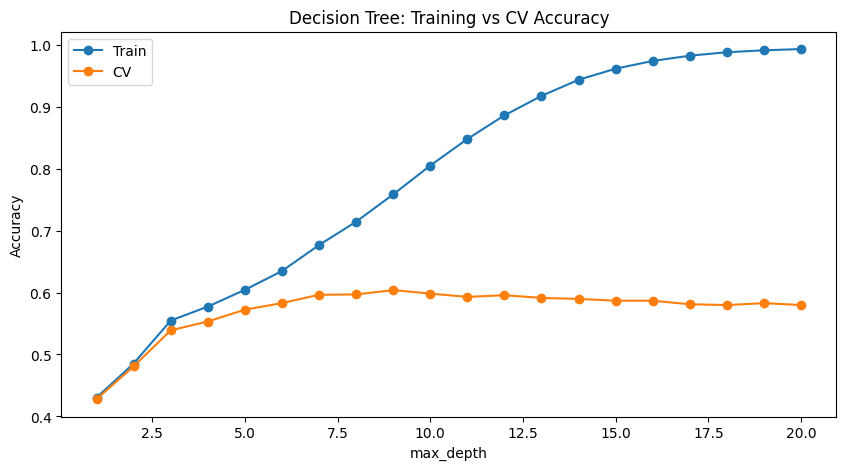

CPU times: total: 875 ms
Wall time: 45.8 s


In [18]:
%%time

# plot max_depth validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
param_range = range(1, 21)
train_scores, val_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train_scaled, y_train,
    param_name="max_depth",
    param_range=param_range,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

plt.figure(figsize=(10,5))
plt.plot(
    param_range,
    train_scores.mean(axis=1),
    marker='o',
    linestyle='-',
    color='C0',
    label="Train"
)
plt.plot(
    param_range,
    val_scores.mean(axis=1),
    marker='o',
    color='C1',
    linestyle='-',
    label="CV"
)
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title('Decision Tree: Training vs CV Accuracy')
plt.legend(loc='best')
plt.show()

In [19]:
%%time

# final model
dt = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=42)

# (re-)fit it on the *entire* training set
dt.fit(X_train_scaled, y_train)

# predict on the test set
y_test_pred = dt.predict(X_test_scaled)

# compute and print your final metrics
test_acc = accuracy_score(y_test, y_test_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

print("--- Final Test-Set Performance ---")
print(f"Test accuracy: {test_acc:.4f}\n")
print("Confusion matrix:")
print(test_cm, "\n")
print("Classification report:")
print(classification_report(y_test, y_test_pred, target_names=dataset.labels))

--- Final Test-Set Performance ---
Test accuracy: 0.6017

Confusion matrix:
[[605 233 162]
 [127 616 257]
 [ 91 325 584]] 

Classification report:
              precision    recall  f1-score   support

    Airplane       0.74      0.60      0.66      1000
        Bird       0.52      0.62      0.57      1000
       Horse       0.58      0.58      0.58      1000

    accuracy                           0.60      3000
   macro avg       0.61      0.60      0.60      3000
weighted avg       0.61      0.60      0.60      3000

CPU times: total: 5.53 s
Wall time: 5.7 s


## 3. Random Forests

[Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifiers use multiple decision trees trained on "weaker" datasets (less data and/or less features), averaging the results so as to reduce over-fitting.

* Use scikit-learn to **create a Random Forest classifier** on the CIFAR data. 
* Use cross-validation to find the best hyper-paramters for this method.

In [20]:
%%time

# classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

# descriptive performance (on full training set)
clf.fit(X_train_scaled, y_train)
y_train_pred = clf.predict(X_train_scaled)
train_acc = accuracy_score(y_train, y_train_pred)
train_cm = confusion_matrix(y_train, y_train_pred)

# print OOB score
print(f"OOB score: {clf.oob_score_:.4f}")

print("--- Descriptive performance ---")
print(f"Training accuracy: {train_acc:.4f}")
print("Training confusion matrix:")
print(train_cm)

# predictive performance (5‑fold cross‑validation)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(
    clf, 
    X_train_scaled, 
    y_train, 
    cv=cv, 
    scoring='accuracy', 
    n_jobs=-1
)
y_cv_pred = cross_val_predict(clf, X_train_scaled, y_train, cv=5)
cv_acc = accuracy_score(y_train, y_cv_pred)
cv_cm = confusion_matrix(y_train, y_cv_pred)

print("\n--- Predictive performance (5‑fold CV) ---")
print("Fold accuracies: ", np.round(cv_scores, 4))
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
print(f"Overall CV accuracy: {cv_acc:.4f}")
print("CV confusion matrix:")
print(cv_cm)

OOB score: 0.7401
--- Descriptive performance ---
Training accuracy: 1.0000
Training confusion matrix:
[[5000    0    0]
 [   0 5000    0]
 [   0    0 5000]]

--- Predictive performance (5‑fold CV) ---
Fold accuracies:  [0.7593 0.7463 0.7593 0.7617 0.761 ]
Mean CV accuracy: 0.7575
Overall CV accuracy: 0.7563
CV confusion matrix:
[[3888  806  306]
 [ 683 3561  756]
 [ 277  827 3896]]
CPU times: total: 3min 42s
Wall time: 33.2 s


In [23]:
%%time

# define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2', None],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'bootstrap': [True, False]
}

# set up and run grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=cv,          
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)

# report best hyperparameters
print("\n--- Hyperparameter search results ---")
print(grid.best_params_)
print(f"Best mean 5‑fold CV accuracy: {grid.best_score_:.4f}")


--- Hyperparameter search results ---
{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Best mean 5‑fold CV accuracy: 0.7657
CPU times: total: 2min 3s
Wall time: 1h 24min 19s


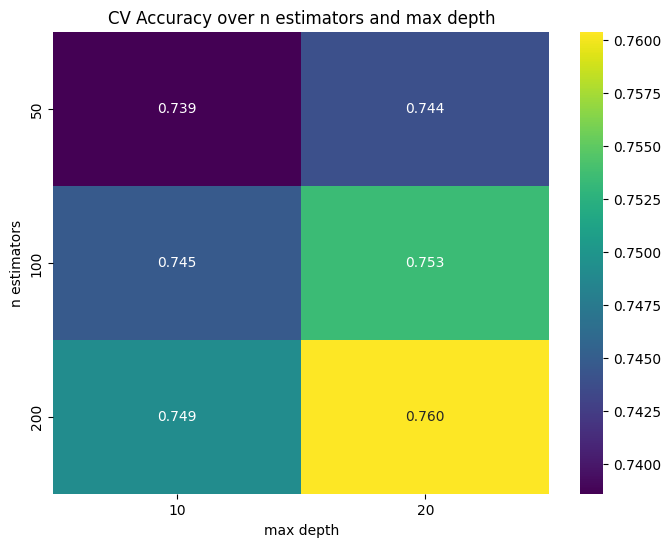

In [29]:
import seaborn as sns
import pandas as pd

results = pd.DataFrame(grid.cv_results_)

# pivot into table: rows=C, columns=gamma
pivot = results.pivot_table(
    index='param_n_estimators',
    columns='param_max_depth',
    values='mean_test_score',
    aggfunc='mean'
).astype(float)

plt.figure(figsize=(8,6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".3f",
    cmap="viridis"
)
plt.xlabel('max depth')
plt.ylabel('n estimators')
plt.title('CV Accuracy over n estimators and max depth')
plt.show()

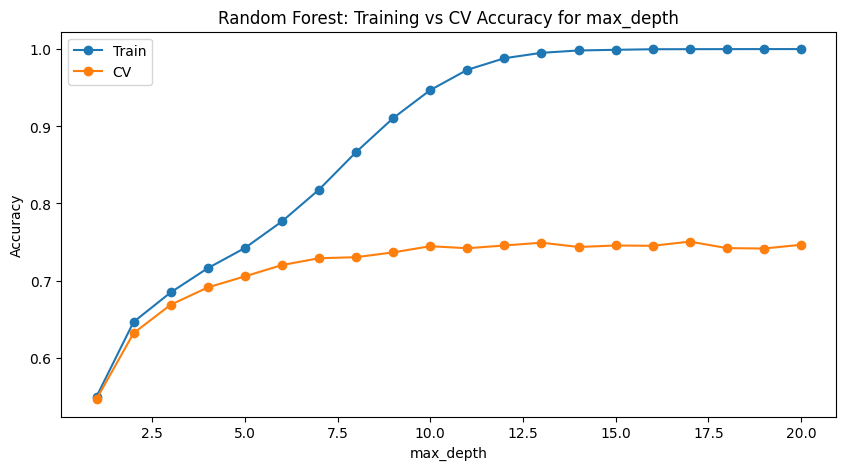

CPU times: total: 1.03 s
Wall time: 1min 36s


In [33]:
%%time

# plot max_depth validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
param_range = range(1, 21)
train_scores, val_scores = validation_curve(
    RandomForestClassifier(n_estimators=50, random_state=42),
    X_train_scaled, y_train,
    param_name="max_depth",
    param_range=param_range,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

plt.figure(figsize=(10,5))
plt.plot(
    param_range,
    train_scores.mean(axis=1),
    marker='o',
    linestyle='-',
    color='C0',
    label="Train"
)
plt.plot(
    param_range,
    val_scores.mean(axis=1),
    marker='o',
    color='C1',
    linestyle='-',
    label="CV"
)
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title('Random Forest: Training vs CV Accuracy for max_depth')
plt.legend(loc='best')
plt.show()

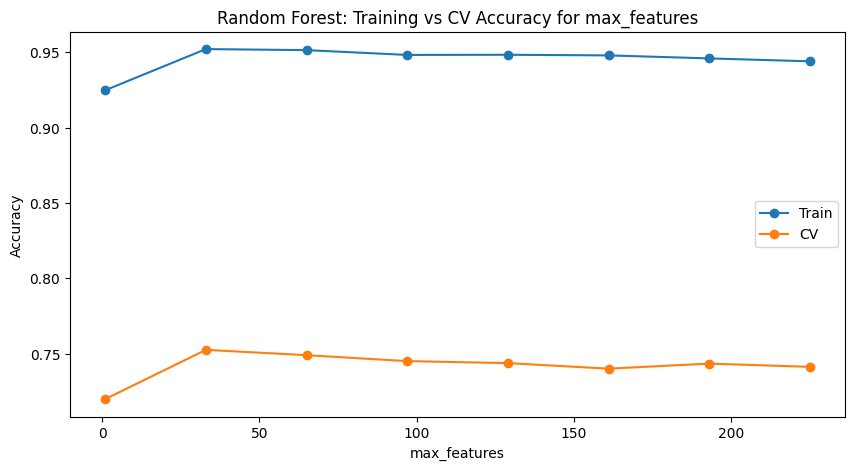

CPU times: total: 203 ms
Wall time: 197 ms


In [32]:
%%time

# plot n features validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
param_range = list(range(1, X_train_scaled.shape[1]+1, 25))
train_scores, val_scores = validation_curve(
    RandomForestClassifier(max_depth=10, n_estimators=100, random_state=0),
    X_train_scaled, y_train,
    param_name="max_features",
    param_range=param_range,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

plt.figure(figsize=(10,5))
plt.plot(
    param_range,
    train_scores.mean(axis=1),
    marker='o',
    linestyle='-',
    color='C0',
    label="Train"
)
plt.plot(
    param_range,
    val_scores.mean(axis=1),
    marker='o',
    color='C1',
    linestyle='-',
    label="CV"
)
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.title('Random Forest: Training vs CV Accuracy for max_features')
plt.legend(loc='best')
plt.show()

In [36]:
%%time

# final model
rf = RandomForestClassifier(max_depth=10, n_estimators=50, random_state=0)

# (re-)fit it on the *entire* training set
rf.fit(X_train_scaled, y_train)

# predict on the test set
y_test_pred = rf.predict(X_test_scaled)

# compute and print your final metrics
test_acc = accuracy_score(y_test, y_test_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

print("--- Final Test-Set Performance ---")
print(f"Test accuracy: {test_acc:.4f}\n")
print("Confusion matrix:")
print(test_cm, "\n")
print("Classification report:")
print(classification_report(y_test, y_test_pred, target_names=dataset.labels))

--- Final Test-Set Performance ---
Test accuracy: 0.7487

Confusion matrix:
[[753 189  58]
 [122 713 165]
 [ 59 161 780]] 

Classification report:
              precision    recall  f1-score   support

    Airplane       0.81      0.75      0.78      1000
        Bird       0.67      0.71      0.69      1000
       Horse       0.78      0.78      0.78      1000

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000

CPU times: total: 14.4 s
Wall time: 15 s


### Compare all models with Pipeline

In [9]:
from sklearn.pipeline import Pipeline

# define the three classifiers
models = {
    'K‑Nearest Neighbors': KNeighborsClassifier(metric='manhattan', n_neighbors=7),
    'Decision Tree': DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=42),
    'Random Forest': RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)
}

# set up a stratified 5-fold splitter for CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# loop over each model
for name, estimator in models.items():
    print(f"\n------ {name} ------")
    
    # build pipeline: standardization + classifier
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', estimator)
    ])
    
    # descriptive performance
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_cm = confusion_matrix(y_train, y_train_pred)
    
    print("-- Descriptive performance --")
    print(f"Training accuracy: {train_acc:.4f}")
    print("Training confusion matrix:")
    print(train_cm)

    # predictive performance (5‑fold cross‑validation)
    cv_scores = cross_val_score(
        pipe, 
        X_train, 
        y_train,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    y_cv_pred = cross_val_predict(
        pipe, X_train, y_train,
        cv=cv,
        n_jobs=-1
    )
    cv_acc = accuracy_score(y_train, y_cv_pred)
    cv_cm = confusion_matrix(y_train, y_cv_pred)
    
    print("\n-- Predictive performance (5‑fold CV) --")
    print("Fold accuracies: ", np.round(cv_scores, 4))
    print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
    print(f"Overall CV accuracy: {cv_acc:.4f}")
    print("CV confusion matrix:")
    print(cv_cm)

    # final Test-Set performance
    pipe.fit(X_train, y_train)
    y_test_pred = pipe.predict(X_test)
    
    test_acc = accuracy_score(y_test, y_test_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)
    
    print("\n-- Final Test-Set Performance --")
    print(f"Test accuracy: {test_acc:.4f}\n")
    print("Confusion matrix:")
    print(f"{test_cm}\n")


------ K‑Nearest Neighbors ------
-- Descriptive performance --
Training accuracy: 0.8475
Training confusion matrix:
[[4175  579  246]
 [ 349 4231  420]
 [  91  602 4307]]

-- Predictive performance (5‑fold CV) --
Fold accuracies:  [0.7773 0.7917 0.7813 0.791  0.785 ]
Mean CV accuracy: 0.7853
Overall CV accuracy: 0.7853
CV confusion matrix:
[[3864  795  341]
 [ 455 3919  626]
 [ 140  864 3996]]

-- Final Test-Set Performance --
Test accuracy: 0.7897

Confusion matrix:
[[782 162  56]
 [ 87 789 124]
 [ 22 180 798]]


------ Decision Tree ------
-- Descriptive performance --
Training accuracy: 0.6691
Training confusion matrix:
[[3432  878  690]
 [ 608 3249 1143]
 [ 378 1267 3355]]

-- Predictive performance (5‑fold CV) --
Fold accuracies:  [0.566  0.6033 0.6063 0.593  0.601 ]
Mean CV accuracy: 0.5939
Overall CV accuracy: 0.5939
CV confusion matrix:
[[3114 1107  779]
 [ 818 2949 1233]
 [ 656 1498 2846]]

-- Final Test-Set Performance --
Test accuracy: 0.6017

Confusion matrix:
[[605 233 1

### Overview of Performance

| Model | Train Acc | CV Acc | Test Acc | Train-Test Gap |
| :--- | :---: | :---: | :---: | :---: |
| K-Nearest Neighbors | 84.75% | 78.53% | 78.97% | ~5.8 pp |
| Decision Tree | 66.91% | 59.39% | 60.17% | ~6.7 pp |
| Random Forest | 93.40% | 74.24% | 74.23% | ~19.2 pp |

- K-Nearest Neighbors
    - **Best generalization:** Test accuracy is approximately **78.97%**.
    - **Moderate overfitting:** There's a manageable drop of about 6 percentage points from training to test accuracy.
    - The confusion matrix shows that errors are balanced across classes.

- Decision Tree
    - **Underfits the data:** It shows low training accuracy (66.9%) and even poorer cross-validation/test accuracy (around 60%).
    - This model is a **poor baseline**, as a single tree struggles to capture the boundaries between classes.

- Random Forest
    - **Strong fit** on training data (93.4%) but suffers from **significant overfitting** (a performance gap of ~19 percentage points).
    - Its cross-validation and test performance (~74.2%) is an improvement over the single Decision Tree but doesn't surpass the K-NN model.

Among the three models evaluated, **K-Nearest Neighbors** delivers the highest test accuracy with the smallest generalization gap. This makes it the most effective baseline model for this particular set of HOG features.

### Compare all models with Pipeline + PCA

In [8]:
# set up a stratified 5-fold splitter for CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# loop over each model
for name, estimator in models.items():
    print(f"\n------ {name} ------")
    
    # build pipeline: standardization + classifier
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.9, whiten=True, random_state=42)),
        ('clf', estimator)
    ])
    
    # descriptive performance
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_cm = confusion_matrix(y_train, y_train_pred)
    
    print("-- Descriptive performance --")
    print(f"Training accuracy: {train_acc:.4f}")
    print("Training confusion matrix:")
    print(train_cm)

    # predictive performance (5‑fold cross‑validation)
    cv_scores = cross_val_score(
        pipe, 
        X_train, 
        y_train,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    y_cv_pred = cross_val_predict(
        pipe, X_train, y_train,
        cv=cv,
        n_jobs=-1
    )
    cv_acc = accuracy_score(y_train, y_cv_pred)
    cv_cm = confusion_matrix(y_train, y_cv_pred)
    
    print("\n-- Predictive performance (5‑fold CV) --")
    print("Fold accuracies: ", np.round(cv_scores, 4))
    print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
    print(f"Overall CV accuracy: {cv_acc:.4f}")
    print("CV confusion matrix:")
    print(cv_cm)

    # final Test-Set performance
    pipe.fit(X_train, y_train)
    y_test_pred = pipe.predict(X_test)
    
    test_acc = accuracy_score(y_test, y_test_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)
    
    print("\n-- Final Test-Set Performance --")
    print(f"Test accuracy: {test_acc:.4f}\n")
    print("Confusion matrix:")
    print(f"{test_cm}\n")


------ K‑Nearest Neighbors ------
-- Descriptive performance --
Training accuracy: 0.7379
Training confusion matrix:
[[3225 1179  596]
 [ 277 4094  629]
 [ 118 1132 3750]]

-- Predictive performance (5‑fold CV) --
Fold accuracies:  [0.6153 0.6453 0.614  0.6107 0.6233]
Mean CV accuracy: 0.6217
Overall CV accuracy: 0.6217
CV confusion matrix:
[[2555 1652  793]
 [ 390 3645  965]
 [ 145 1729 3126]]

-- Final Test-Set Performance --
Test accuracy: 0.6357

Confusion matrix:
[[528 345 127]
 [ 78 751 171]
 [ 30 342 628]]


------ Decision Tree ------
-- Descriptive performance --
Training accuracy: 0.7209
Training confusion matrix:
[[3626  954  420]
 [ 499 3462 1039]
 [ 200 1075 3725]]

-- Predictive performance (5‑fold CV) --
Fold accuracies:  [0.6537 0.6767 0.6637 0.6553 0.6727]
Mean CV accuracy: 0.6644
Overall CV accuracy: 0.6644
CV confusion matrix:
[[3414 1018  568]
 [ 763 2854 1383]
 [ 293 1009 3698]]

-- Final Test-Set Performance --
Test accuracy: 0.6570

Confusion matrix:
[[654 254  